# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [10]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [2]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.64,784.0,343.0,220.50,3.5,2,0.25,5,16.73,20.13
1,0.98,514.5,294.0,110.25,7.0,2,0.40,4,32.85,32.95
2,0.66,759.5,318.5,220.50,3.5,3,0.25,2,12.93,15.85
3,0.64,784.0,343.0,220.50,3.5,5,0.25,4,16.62,19.90
4,0.98,514.5,294.0,110.25,7.0,4,0.40,3,32.23,33.86


In [4]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
train_stats

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.764463,671.834691,318.659609,176.587541,5.232899,3.500000,0.237378,2.811075,22.330912,24.600195
std,0.107605,89.266386,44.474260,45.624109,1.751343,1.120403,0.133803,1.573685,10.146585,9.502568
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000,10.900000
25%,0.667500,594.125000,294.000000,122.500000,3.500000,2.000000,0.100000,1.000000,13.040000,15.645000
50%,0.740000,686.000000,318.500000,220.500000,3.500000,4.000000,0.250000,3.000000,18.595000,21.700000
75%,0.850000,753.375000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,32.037500,33.237500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000,48.030000


In [7]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.764463,0.107605,0.62,0.6675,0.74,0.850,0.98
X2,614.0,671.834691,89.266386,514.50,594.1250,686.00,753.375,808.50
X3,614.0,318.659609,44.474260,245.00,294.0000,318.50,343.000,416.50
X4,614.0,176.587541,45.624109,110.25,122.5000,220.50,220.500,220.50
X5,614.0,5.232899,1.751343,3.50,3.5000,3.50,7.000,7.00
X6,614.0,3.500000,1.120403,2.00,2.0000,4.00,4.000,5.00
X7,614.0,0.237378,0.133803,0.00,0.1000,0.25,0.400,0.40
X8,614.0,2.811075,1.573685,0.00,1.0000,3.00,4.000,5.00


In [8]:
train_stats['mean']

X1      0.764463
X2    671.834691
X3    318.659609
X4    176.587541
X5      5.232899
X6      3.500000
X7      0.237378
X8      2.811075
Name: mean, dtype: float64

In [11]:
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [12]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [14]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 944us/sample - loss: 249.9499 - y1_output_loss: 117.9033 - y2_output_loss: 129.9411 - y1_output_root_mean_squared_error: 10.9072 - y2_output_root_mean_squared_error: 11.4448 - val_loss: 56.9086 - val_y1_output_loss: 18.2340 - val_y2_output_loss: 37.6445 - val_y1_output_root_mean_squared_error: 4.3145 - val_y2_output_root_mean_squared_error: 6.1882
Epoch 2/500
614/614 [==============================] - 0s 133us/sample - loss: 34.5779 - y1_output_loss: 13.3752 - y2_output_loss: 21.1305 - y1_output_root_mean_squared_error: 3.6613 - y2_output_root_mean_squared_error: 4.6014 - val_loss: 27.4863 - val_y1_output_loss: 10.7753 - val_y2_output_loss: 16.0193 - val_y1_output_root_mean_squared_error: 3.3190 - val_y2_output_root_mean_squared_error: 4.0584
Epoch 3/500
614/614 [==============================] - 0s 129us/sample - loss: 26.7205 - y1_output_loss: 10.4732 - y2_output_loss: 16.4054 - y1

## Evaluate the Model and Plot Metrics

In [15]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 407us/sample - loss: 0.9656 - y1_output_loss: 0.2372 - y2_output_loss: 0.7164 - y1_output_root_mean_squared_error: 0.4902 - y2_output_root_mean_squared_error: 0.8516
Loss = 0.9655960341552635, Y1_loss = 0.2372409850358963, Y1_mse = 0.4902375340461731, Y2_loss = 0.7163674831390381, Y2_mse = 0.8516238331794739


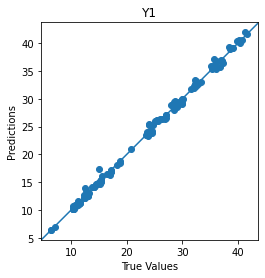

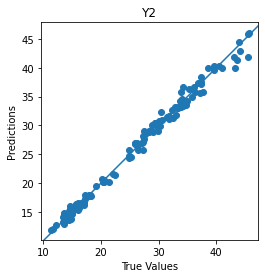

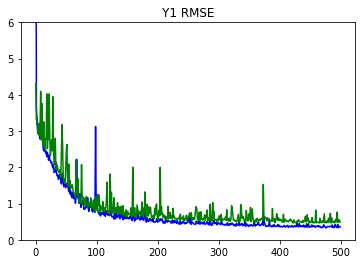

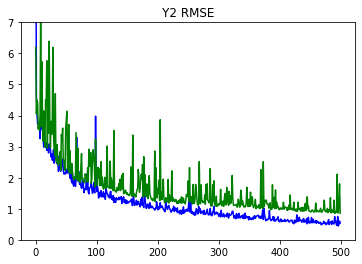

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)